In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [2]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_1f1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   
e16_1f1     0   e16_1f1_200823       e16_1f1  2020-08-23   
            1   e16_1f1_200824       e16_1f1  2020-08-24   
e14_2m3     0   e14_2m3_201017       e14_2m3  2020-10-17   
            1   e14_2m3_201019       e14_2m3  2020-10-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     0                    alternation     0.636364       11   
e16_1f1     0                    alternation     0.631579       19   
            1                    alternation     0.571429       21   
e14_2m3     0                    alternation     0.615385       26   
            1                    alternation     0.863636       22   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     0           11         50              37  roman  roman_data  
e16_1f1     0           19         47              32  roman  roman_data  
            1           21         40              27  roman  roman_data  
e14_2m3     0           26         34              26  roman  roman_data  
            1           22         36              22  roman  roman_data  

[67 rows x 12 columns]

In [3]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [4]:
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat',filtered='*thetaFiltered*.mat')
# sessionPulses=mat_to_return['sessionPulses']
filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)


load *SessionPulses.Events.mat failed


In [5]:
import nmf_one_session as nos
from itertools import product
reload(nos)
condition_df = {'do_normalize':[True,False],'speed_thresh':[0,1,5],'israte':[True,False]}
condition_df = pd.DataFrame(list(product(*condition_df.values())),columns=list(condition_df.keys()))
n_compo = 4
nmf_res_d = {}

for _,combo in condition_df.iterrows():
    do_normalize,speed_thresh,israte = combo['do_normalize'],combo['speed_thresh'],combo['israte']
    res_to_save_name = f'nmf_{n_compo}_normalize_{do_normalize}_speedthresh_{int(speed_thresh)}_rate_{israte}'
    nmf_res_d[tuple(combo.values)]=nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'doplots':False,'n_clust':6,'do_normalize':do_normalize,'force_reload':False,'dosave':False,'speed_thresh':speed_thresh,'res_to_save_name':res_to_save_name,'israte':israte})



<module 'sys' (built-in)>
<module 'sys' (built-in)>
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_0_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_0_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_5_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_5_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_2

In [7]:
donormalize=True
X_restacked_df_d=nmf_res_d[(donormalize,1,True)]['X_normed_restacked_df_d']
W_df_peaks_only_d=nmf_res_d[(donormalize,1,True)]['W_df_peaks_only_d']

key=(0,1)
X_peaks = X_restacked_df_d[key].loc[W_df_peaks_only_d[key].index]
X = X_peaks
sigma=1
X_peaks_smth = scipy.ndimage.gaussian_filter1d(X_peaks,sigma,axis=1)
X_peaks_smth = pd.DataFrame(X_peaks_smth,index=X_peaks.index,columns=X_peaks.columns)

In [10]:
reload(cpa)

<module 'change_point_analysis' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py'>

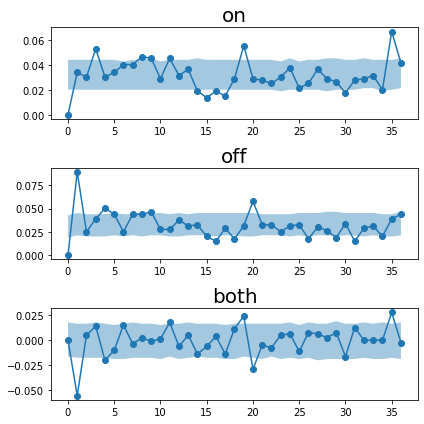

In [180]:
reload(cpa)

_=cpa.test_switch_ratio_wrapper(X,low=0.1,high=0.5,doplots=True,nrepeats=1000)

In [ ]:
reload(cpa)
import tqdm
cdf_d_d = {}
for high in tqdm.tqdm([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):
    cdf_d=test_switch_ratio_wrapper(X,low=0.1,high=high,doplots=False,nrepeats=1000)
    cdf_d_d[high]=cdf_d
cdf_d_d=pd.concat(cdf_d_d).unstack()

sig_d_d = (cdf_d_d>1-alpha/2)|(cdf_d_d<alpha/2)

In [ ]:
fig,axs = plt.subplots(3,1,figsize=(6,6))
for ii,k in enumerate(['on','off','both']):
    axs[ii]=sns.heatmap(cdf_d_d[k],mask=~sig_d_d[k],xticklabels=cdf_d_d[k].columns.values.astype(int),ax=axs[ii])
    axs[ii].set_title(k)
    axs[ii].set_ylabel('threshold',fontsize=12)
plt.tight_layout()

# compare with old, simple threshold

In [216]:
reload(cpa)
import tqdm
cdf_d_d = {}
for high in tqdm.tqdm([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):
    cdf_d=test_switch_ratio_wrapper(X,low=high,high=high,doplots=False,nrepeats=1000)
    cdf_d_d[high]=cdf_d
cdf_d_d=pd.concat(cdf_d_d).unstack()

sig_d_d = (cdf_d_d>1-alpha/2)|(cdf_d_d<alpha/2)

100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


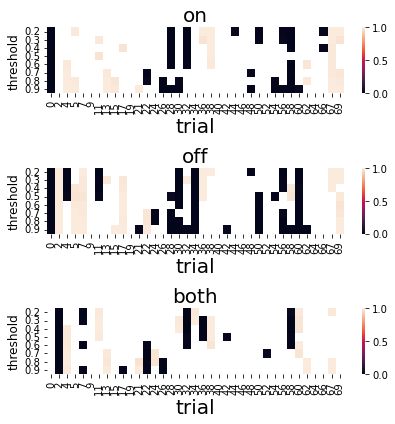

In [217]:
fig,axs = plt.subplots(3,1,figsize=(6,6))
for ii,k in enumerate(['on','off','both']):
    axs[ii]=sns.heatmap(cdf_d_d[k],mask=~sig_d_d[k],xticklabels=cdf_d_d[k].columns.values.astype(int),ax=axs[ii])
    axs[ii].set_title(k)
    axs[ii].set_ylabel('threshold',fontsize=12)
plt.tight_layout()

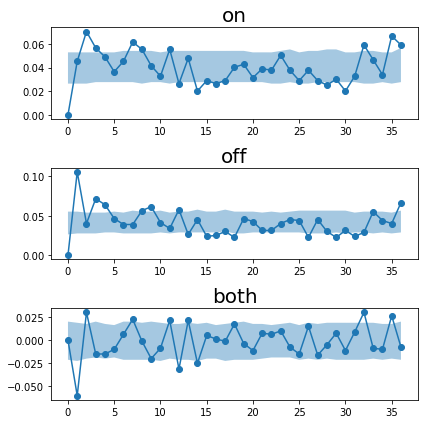

In [220]:
_=cpa.test_switch_ratio_wrapper(X,low=0.8,high=0.8,doplots=True,nrepeats=1000)



# distribution

In [279]:
X_restacked_df_d=nmf_res_d[(False,1,True)]['X_normed_restacked_df_d']
W_df_peaks_only_d=nmf_res_d[(False,1,True)]['W_df_peaks_only_d']

key=(0,0)
X_peaks = X_restacked_df_d[key].loc[W_df_peaks_only_d[key].index]
X = X_peaks
sigma=1
X_peaks_smth = scipy.ndimage.gaussian_filter1d(X_peaks,sigma,axis=1)
X_peaks_smth = pd.DataFrame(X_peaks_smth,index=X_peaks.index,columns=X_peaks.columns)

In [280]:
switch_on,switch_off,changes_df = cpa.detect_switch_by_change(X,thresh_ratio_low=0.1,thresh_ratio_high=0.8)

In [284]:
field_any_change = changes_df.loc[(changes_df==-1).any(axis=1)].index.get_level_values(level=1)

In [285]:
field_counts=changes_df.index.get_level_values(level=1).value_counts()
field_any_change_counts = field_any_change.value_counts()
field_any_change_percent = field_any_change_counts / field_counts

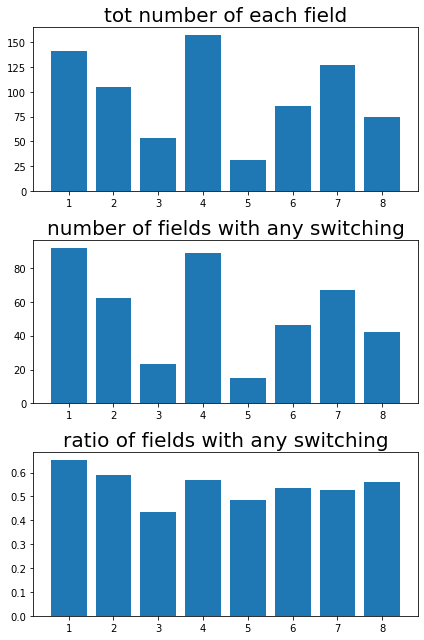

In [286]:
fig,axs = plt.subplots(3,1,figsize=(6,9))
axs[0].bar(field_counts.index,field_counts)
axs[0].set_title('tot number of each field')
axs[1].bar(field_any_change_counts.index,field_any_change_counts)
axs[1].set_title('number of fields with any switching')
axs[2].bar(field_any_change_percent.index,field_any_change_percent)
axs[2].set_title('ratio of fields with any switching')
plt.tight_layout()

In [339]:
switch_field_count_per_trial_l = {}
onoff=-1
for tt in changes_df.columns:
    col = changes_df.loc[:,tt]
    switch_field_count_per_trial=col.loc[(col==onoff)].index.get_level_values(level=1).value_counts()
    switch_field_count_per_trial_l[tt]=switch_field_count_per_trial
switch_field_count_per_trial_l=pd.concat(switch_field_count_per_trial_l)
switch_field_count_per_trial_l=switch_field_count_per_trial_l.unstack().T # bins x trials
switch_field_count_per_trial_l_ratio=switch_field_count_per_trial_l / field_counts.loc[switch_field_count_per_trial_l.index].values[:,None]
# plt.hist(col.loc[(col==1)].index.get_level_values(level=1))

<AxesSubplot:>

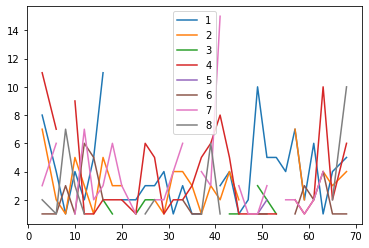

In [340]:
switch_field_count_per_trial_l.T.plot()

<AxesSubplot:>

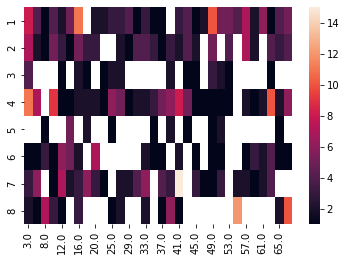

In [341]:
sns.heatmap(switch_field_count_per_trial_l)

# compare to population cpd

In [404]:
import nmf_cpd as nc
reload(nc)
Xval = X.values
n_compo = 5
n_bkps = 2
w_,h_,bkps_l,err_tot_l = nc.nmf_pwc_h_fit(Xval,n_compo,n_bkps=n_bkps,max_iters_outer=10,max_iters_rank1=4,tol=1e-8,w_init=None,h_init=None)
inds,h_=na.sort_by_peak_within_factor(h_)
bkps_l = bkps_l[inds]
w_=w_[:,inds]


In [411]:
cdf_d_d['on'].iloc[:,5]

0.2    0.978
0.3    0.937
0.4    0.338
0.5    0.626
0.6    0.484
0.7    0.272
0.8    0.112
0.9    0.092
Name: 9.0, dtype: float64

In [405]:
print('significantly higher',np.nonzero((cdf_d_d['on'].loc[0.9] > 0.975).values))
print('significantly lower',np.nonzero((cdf_d_d['on'].loc[0.9] < 0.025).values))

significantly higher (array([ 3,  8, 19, 35]),)
significantly lower (array([ 0, 10, 14, 15, 16, 17, 25, 30]),)


In [436]:
print('significantly higher',np.nonzero((cdf_d_d['off'].loc[0.9] > 0.975).values))
print('significantly lower',np.nonzero((cdf_d_d['off'].loc[0.9] < 0.025).values))

significantly higher (array([ 1,  3,  4,  9, 20, 36]),)
significantly lower (array([ 0, 11, 16, 17, 18, 26, 27, 29, 31]),)


In [437]:
bkps_l

array([array([ 0,  2, 20, 37]), array([ 0,  2,  5, 37]),
       array([ 0,  5, 19, 37]), array([ 0, 20, 35, 37]),
       array([ 0, 16, 35, 37])], dtype=object)

In [414]:
on_points_from_cpd=np.array([xx[1] for xx in bkps_l[1:-1]]+[bkps_l[-1][2]])

In [416]:
on_points_from_cpd

array([ 2,  5, 20, 35])

In [439]:
cdf_d_d['off'].iloc[:,9]

0.2    0.964
0.3    0.986
0.4    0.984
0.5    0.982
0.6    0.985
0.7    0.980
0.8    0.993
0.9    0.997
Name: 17.0, dtype: float64

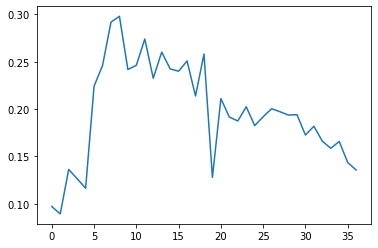

In [427]:
plt.plot(X.loc[w_.argmax(axis=1)==2].mean(axis=0).values)

(<Figure size 1026x1144.8 with 4 Axes>,
 {'W': <AxesSubplot:label='W', xlabel='component', ylabel='neuron'>,
  'H': <AxesSubplot:label='H', ylabel='component'>})

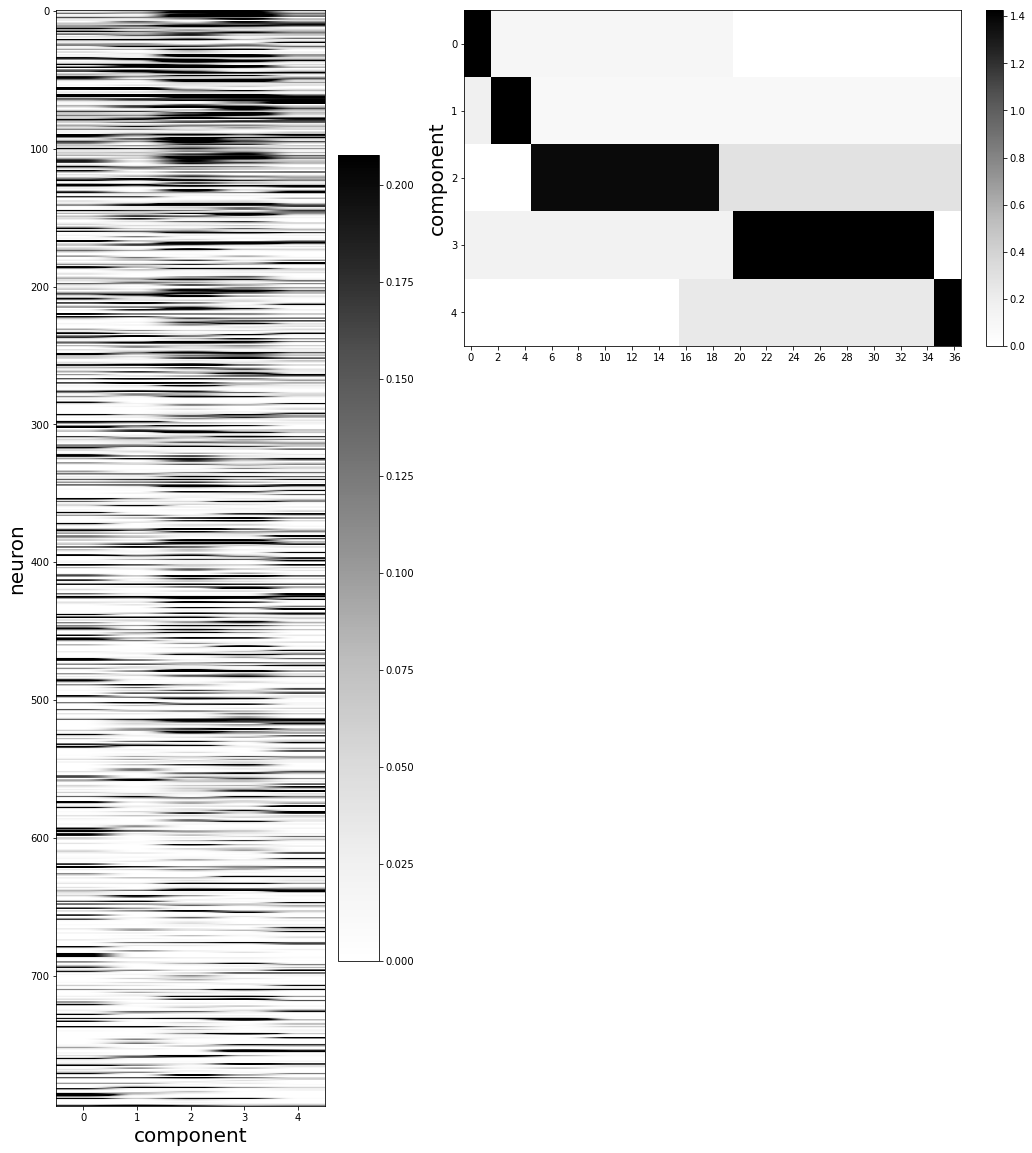

In [407]:
nmfp.plot_wh(w_,h_)

# low switching trials

In [544]:
cdf_d_d['on'] 

trial,0.0,2.0,4.0,5.0,7.0,9.0,11.0,13.0,15.0,17.0,...,52.0,54.0,56.0,58.0,60.0,62.0,64.0,66.0,67.0,69.0
0.2,0.0,0.644,0.707,1.000,0.145,0.978,0.922,0.261,0.827,0.965,...,0.472,0.088,0.015,0.001,0.840,0.204,0.483,0.006,1.0,0.967
0.3,0.0,0.494,0.292,1.000,0.355,0.937,0.991,0.746,0.964,0.950,...,0.598,0.211,0.005,0.000,0.605,0.165,0.493,0.049,1.0,0.881
0.4,0.0,0.406,0.381,0.998,0.377,0.338,0.796,0.920,0.983,0.986,...,0.640,0.611,0.030,0.000,0.321,0.125,0.478,0.036,1.0,0.940
0.5,0.0,0.625,0.395,0.999,0.404,0.626,0.907,0.910,0.989,0.982,...,0.758,0.289,0.153,0.002,0.217,0.299,0.449,0.022,1.0,0.915
0.6,0.0,0.821,0.546,1.000,0.431,0.484,0.829,0.838,0.990,0.974,...,0.585,0.162,0.014,0.002,0.236,0.505,0.565,0.108,1.0,0.893
0.7,0.0,0.912,0.742,0.999,0.430,0.272,0.873,0.827,0.994,0.895,...,0.647,0.175,0.008,0.004,0.185,0.748,0.728,0.137,1.0,0.937
0.8,0.0,0.957,0.514,0.999,0.584,0.112,0.950,0.791,0.998,0.580,...,0.337,0.059,0.030,0.000,0.033,0.860,0.589,0.142,1.0,0.932
0.9,0.0,0.930,0.734,1.000,0.650,0.092,0.909,0.785,1.000,0.414,...,0.555,0.031,0.051,0.000,0.026,0.556,0.769,0.084,1.0,0.971


In [441]:
cdf_d_d['on'] <0.025

trial,0.0,2.0,4.0,5.0,7.0,9.0,11.0,13.0,15.0,17.0,...,52.0,54.0,56.0,58.0,60.0,62.0,64.0,66.0,67.0,69.0
0.2,True,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,True,False,False
0.3,True,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
0.4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
0.5,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
0.6,True,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
0.7,True,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
0.8,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
0.9,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [549]:
switch_on,switch_off,changes_df = cpa.detect_switch_by_change(X,thresh_ratio_low=0.1,thresh_ratio_high=0.8)

In [550]:
switch_on[58]

     lin_binned
3    3             False
27   1             False
     6             False
29   3             False
     6             False
                   ...  
479  1             False
     6             False
     8             False
480  3             False
     7             False
Name: 58.0, Length: 795, dtype: bool

In [551]:
switch_on[58].sum()

3

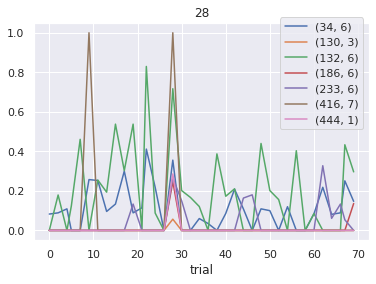

In [564]:
kk=28
# X.loc[switch_on.iloc[:,kk]].T.plot(title=switch_on.columns[kk]).legend(bbox_to_anchor=[1,1.05])
X.loc[switch_on.loc[:,kk]].T.plot(title=kk).legend(bbox_to_anchor=[1,1.05])

In [462]:
filtered['timestamps']

array([0.00000000e+00, 8.00000039e-04, 1.60000008e-03, ...,
       1.65619504e+04, 1.65619512e+04, 1.65619520e+04])

In [472]:
theta_df=dpp.get_theta_df(filtered)

In [474]:
beh_df

,lin,x,y,trial,task_index,task,speed,vel_x,vel_y,visitedArm,correct,v,trial_type
Time (s),,,,,,,,,,,,,
7858.227233,16.306144,64.774218,50.034836,NaN,0,alternation,0.000000,0.000000,0.000000,NaN,NaN,NaN,None
7858.260567,16.217524,64.791278,50.017189,NaN,0,alternation,0.165125,0.160125,-0.040326,NaN,NaN,NaN,None
7858.293933,16.217524,64.856234,49.943440,NaN,0,alternation,0.330024,0.320033,-0.080589,NaN,NaN,NaN,None
7858.327267,16.128903,64.939760,49.792814,NaN,0,alternation,0.494481,0.479514,-0.120738,NaN,NaN,NaN,None
7858.360600,16.040283,64.958083,49.648549,NaN,0,alternation,0.658282,0.638357,-0.160732,NaN,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10017.539300,215.848359,91.759619,49.629031,69.0,0,alternation,0.075932,0.011506,0.075055,1.0,1.0,NaN,"(0, 1.0)"
10017.572633,215.496837,91.444089,49.966782,69.0,0,alternation,0.060797,0.009124,0.060108,1.0,1.0,NaN,"(0, 1.0)"
10017.605967,215.233195,91.139881,50.283213,69.0,0,alternation,0.045635,0.006792,0.045126,1.0,1.0,NaN,"(0, 1.0)"


In [487]:
reload(dpp)
beh_df_with_theta,theta_df_beh = dpp.merge_theta_into_beh_df(theta_df,beh_df)

In [489]:
import trial_correlates as tc

In [504]:
theta_amp_stats=tc.get_variable_statistics_per_trial(beh_df_with_theta.query('speed>1'), key='theta_amp')

In [498]:
key

(0, 1)

In [567]:
cdf_d_d['on'].T

,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
trial,,,,,,,,
0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2.0,0.644,0.494,0.406,0.625,0.821,0.912,0.957,0.930
4.0,0.707,0.292,0.381,0.395,0.546,0.742,0.514,0.734
5.0,1.000,1.000,0.998,0.999,1.000,0.999,0.999,1.000
7.0,0.145,0.355,0.377,0.404,0.431,0.430,0.584,0.650
9.0,0.978,0.937,0.338,0.626,0.484,0.272,0.112,0.092
11.0,0.922,0.991,0.796,0.907,0.829,0.873,0.950,0.909
13.0,0.261,0.746,0.920,0.910,0.838,0.827,0.791,0.785
15.0,0.827,0.964,0.983,0.989,0.990,0.994,0.998,1.000


In [579]:
scipy.stats.pearsonr(theta_amp_stats.loc[key]['theta_amp_mean'],cdf_d_d['on'].T[0.2])

(-0.0815360471300732, 0.6314110011934579)

In [580]:
speed_stats = tc.get_variable_statistics_per_trial(beh_df,key='speed')

In [584]:
scipy.stats.pearsonr(speed_stats.loc[key]['speed_mean'],cdf_d_d['on'].T[0.9])

(-0.027504515113673786, 0.8716274982985774)

In [585]:
firing_related=tc.get_firing_related_per_trial(spk_beh_df,cell_cols_d)

In [586]:
firing_related

mean_fr_pyr  frac_active_pyr  mean_fr_int  frac_active_int  \
trial_type trial                                                               
(0, 0.0)   1.0       0.033104         0.879147     0.529457         0.983333   
           3.0       0.033513         0.827014     0.527156         0.983333   
           6.0       0.031511         0.860190     0.496966         0.983333   
           8.0       0.032298         0.791469     0.506244         0.983333   
           10.0      0.033913         0.872038     0.507950         0.983333   
...                       ...              ...          ...              ...   
(0, 1.0)   62.0      0.034357         0.940758     0.462670         0.983333   
           64.0      0.032656         0.886256     0.446777         0.983333   
           66.0      0.034326         0.881517     0.480794         0.983333   
           67.0      0.039669         0.855450     0.590611         1.000000   
           69.0      0.040205         0.938389     0.605466         0.983333   

                  mean_fr_ratio  frac_active_ratio  
trial_type trial                                    
(0, 0.0)   1.0         0.062524           0.894048  
           3.0         0.063573           0.841031  
           6.0         0.063407           0.874769  
           8.0         0.063799           0.804884  
           10.0        0.066765           0.886818  
...                         ...                ...  
(0, 1.0)   62.0        0.074258           0.956703  
           64.0        0.073092           0.901277  
           66.0        0.071395           0.896458  
           67.0        0.067165           0.855450  
           69.0        0.066403           0.954294  

[70 rows x 6 columns]

In [588]:
scipy.stats.pearsonr(firing_related.loc[key]['mean_fr_pyr'],cdf_d_d['on'].T[0.9])

(0.22504344201445325, 0.18052039295090674)

<AxesSubplot:xlabel='trial'>

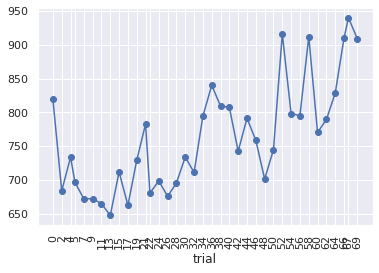

In [507]:
theta_amp_stats.loc[key]['theta_amp_mean'].plot(xticks=theta_amp_stats.loc[key].index,rot=90,marker='o')

<AxesSubplot:xlabel='trial'>

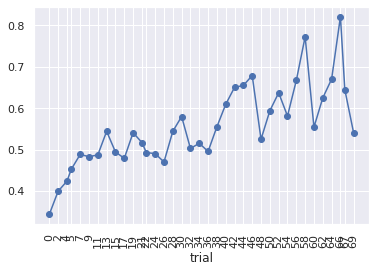

In [508]:
theta_amp_stats.loc[key]['theta_amp_cv'].plot(xticks=theta_amp_stats.loc[key].index,rot=90,marker='o')

# non-running spikes

In [ ]:
spk_beh_df[cell_cols_d['pyr']].corr()